In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cm
import datetime as dt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import pickle 
import os
from salishsea_tools import viz_tools, geo_tools
import arrow
import copy
import math
import matplotlib.dates as mdates



from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

import gsw

from mpl_toolkits.basemap import Basemap

In [2]:
mycmap = copy.copy(cm.oxy)
mycmap.set_bad('darkgreen')

# BASEMAP PLOTTING CODE

In [3]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    #lines = np.loadtxt('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/SaanichInlet_VictoriaSill_thalweg.txt', delimiter=" ", unpack=False)
    #lines = np.loadtxt('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Hood_Canal_thalweg.txt', delimiter=" ", unpack=False)

    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')

# LOAD GRID

In [4]:
meshmask = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc')
grid = xr.open_dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc', mask_and_scale=False)

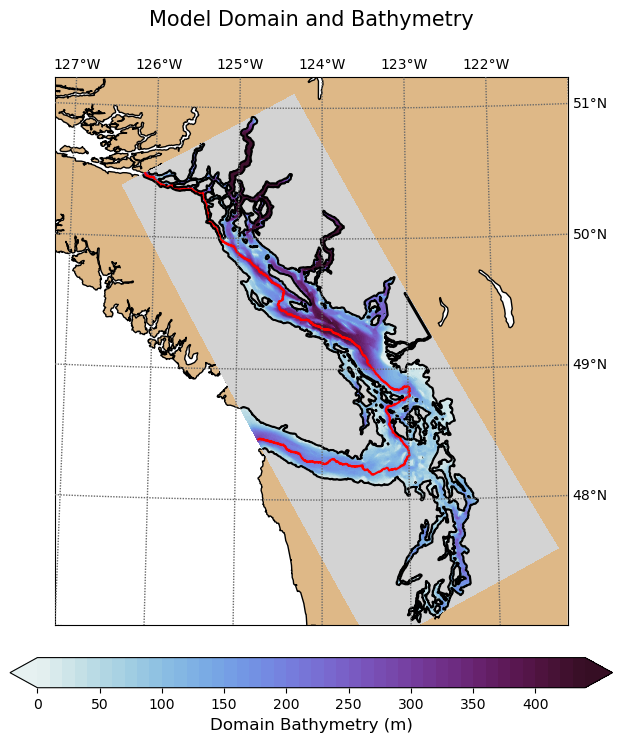

In [5]:
#set plot parameters
#scaling factor 
fact = 1
fs = 12
dicmin_twg = 1900
dicmax_twg = 2300
dicmin_surf = 0
dicmax_surf = 450
dicstep = 10

fig = plt.figure(figsize=(6.5*fact, 7.5*fact))

#domain plot - BR run summer average
ax1 = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1) 

w_map = [-127, -121, 47, 51.2]
m = plot_basemap(ax1, w_map, zorder=[0, 1, 7]) #offset=[-30000, -15000]
x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)  
#define data to plot as the surface level of the summer dataset
tdat_p = grid['Bathymetry'][:,:]
mesh = ax1.contourf(x, y, tdat_p, levels=np.arange(dicmin_surf, dicmax_surf, dicstep), \
                 cmap=cm.dense, extend = 'both') # extend='both', zorder=.2)

ax1.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
ax1.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)
plot_thalweg(ax1, x, y)
ax1.set_title('Model Domain and Bathymetry',fontsize = fs+3, y=1.08)

cbar = fig.colorbar(mesh, ax=ax1, orientation = 'horizontal',fraction=0.1, pad=0.05)
cbar.set_label(label='Domain Bathymetry (m)', size=fs)
#ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')

plt.tight_layout()
#fig.savefig('SF_modeldomain.png',dpi = 300)

In [6]:
thalweg_SI = '/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/SaanichInlet_VictoriaSill_thalweg.txt'
thalweg_HC = '/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/Hood_Canal_thalweg.txt'
thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'

mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')

meshb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
bathyb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc')

depthb = meshb.variables['gdept_0'][:]
thalweg_pts0 = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
thalweg_pts = np.loadtxt(thalweg_SI, delimiter=' ', dtype=int)
thalweg_ptsHC = np.loadtxt(thalweg_HC, delimiter=' ', dtype=int)

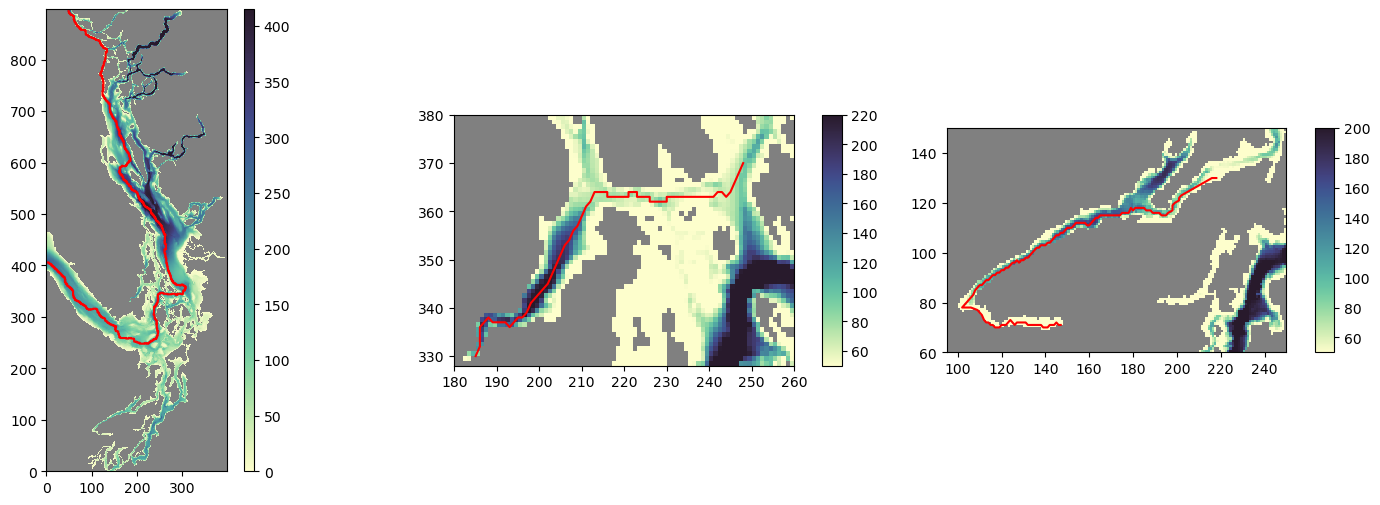

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 3, figsize=(18, 6))
mycmap = cm.deep
mycmap.set_bad('grey')
im = ax[0].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=0, vmax=415)
ax[0].plot(thalweg_pts0[:,1],thalweg_pts0[:,0],color='r')
im2 = ax[1].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=50, vmax=220)
ax[1].plot(thalweg_pts[:,1],thalweg_pts[:,0],color='r')
im3 = ax[2].pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=50, vmax=200)
ax[2].plot(thalweg_ptsHC[:,1],thalweg_ptsHC[:,0],color='r')
viz_tools.set_aspect(ax[0]);
viz_tools.set_aspect(ax[1]);
viz_tools.set_aspect(ax[2]);
#ax[0].set_xlim([180, 260])
#ax[0].set_ylim([328, 380])
ax[1].set_xlim([180, 260])
ax[1].set_ylim([328, 380])
ax[2].set_xlim([95, 250])
ax[2].set_ylim([60, 150])
divider = make_axes_locatable(ax[0])
divider2 = make_axes_locatable(ax[1])
divider3 = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')

In [8]:
# SalishSeaCast zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0, Z2eff=0
df_chemTlr0 = nc.Dataset('/ocean/atall/MOAD/Model/runs/salishseacast/long_run/SalishSea_1d_chemo2_20180101_20181231.nc')
df_biolTlr0 = nc.Dataset('/ocean/atall/MOAD/Model/runs/salishseacast/long_run/SalishSea_1d_PON_20180101_20181130.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.10
df_chemTlr1 = nc.Dataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/run_first_Bremin10/SalishSea_1d_chemo2_20180101_20181231.nc')
df_biolTlr1 = nc.Dataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/run_first_Bremin10/SalishSea_1d_PON_20180101_20181130.nc')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.60
df_chemTlr2 = nc.Dataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/SalishSea_1d_chemo2_20180101_20181130.nc')
df_biolTlr2 = nc.Dataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/SalishSea_1d_PON_20180101_20181130.nc')


# Strait of Georgia

Text(0.5, 0.98, 'November 6th, 2018')

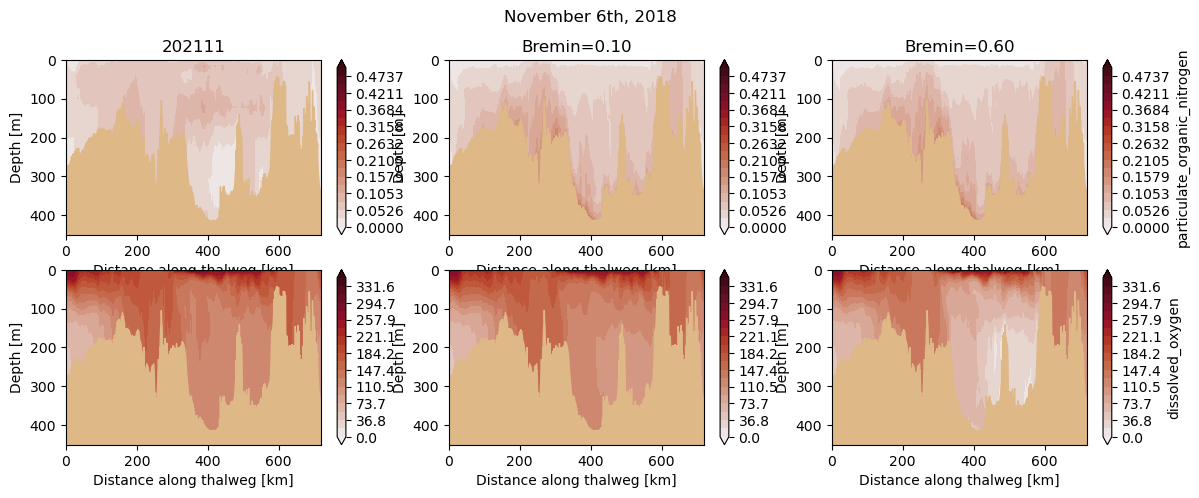

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (14, 5))
tt = 310
modvar1='particulate_organic_nitrogen'
modvar2='dissolved_oxygen'
level_pon = np.linspace(0,0.5,20)
level_oxy = np.linspace(0,350,20)
old0=vis.contour_thalweg(ax[0,0],df_biolTlr0.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':''})
new1=vis.contour_thalweg(ax[0,1],df_biolTlr1.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':''})
new2=vis.contour_thalweg(ax[0,2],df_biolTlr2.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':modvar1})
old0=vis.contour_thalweg(ax[1,0],df_chemTlr0.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':''})
new1=vis.contour_thalweg(ax[1,1],df_chemTlr1.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':''})
new2=vis.contour_thalweg(ax[1,2],df_chemTlr2.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_SoG,cbar_args={'label':modvar2})

ax[0,0].set_ylim([450, 0])
ax[0,1].set_ylim([450, 0])
ax[0,2].set_ylim([450, 0])
ax[1,0].set_ylim([450, 0])
ax[1,1].set_ylim([450, 0])
ax[1,2].set_ylim([450, 0])
ax[0,0].set_title('202111')
ax[0,1].set_title('Bremin=0.10')
ax[0,2].set_title('Bremin=0.60')
fig.suptitle('November 6th, 2018')


# Saanich Inlet

Text(0.5, 0.98, 'November 6th, 2018')

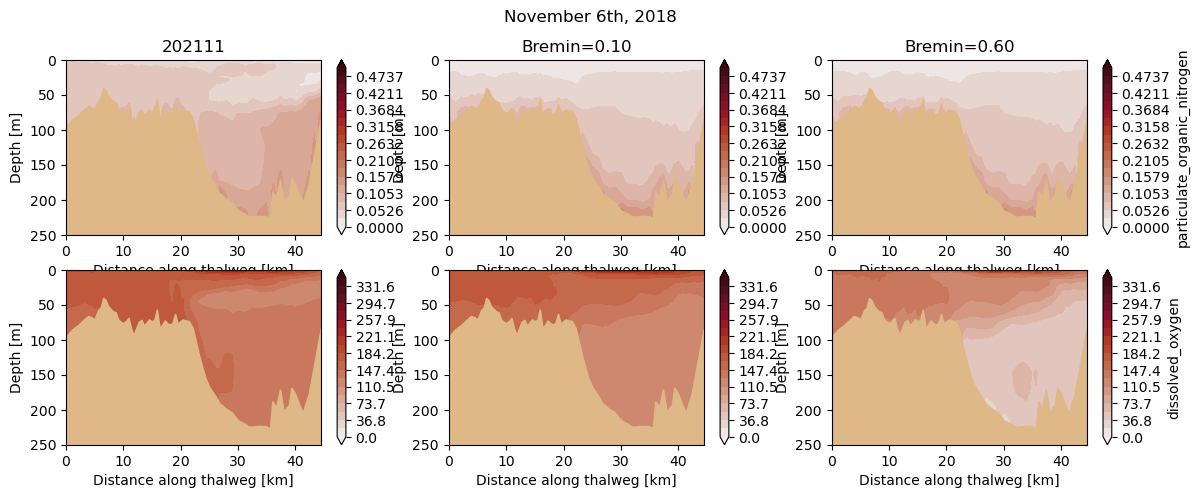

In [10]:
fig, ax = plt.subplots(2, 3, figsize = (14, 5))
old0=vis.contour_thalweg(ax[0,0],df_biolTlr0.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_SI,cbar_args={'label':''})
new1=vis.contour_thalweg(ax[0,1],df_biolTlr1.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_SI,cbar_args={'label':''})
new2=vis.contour_thalweg(ax[0,2],df_biolTlr2.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_SI,cbar_args={'label':modvar1})
old0=vis.contour_thalweg(ax[1,0],df_chemTlr0.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_SI,cbar_args={'label':''})
new1=vis.contour_thalweg(ax[1,1],df_chemTlr1.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_SI,cbar_args={'label':''})
new2=vis.contour_thalweg(ax[1,2],df_chemTlr2.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_SI,cbar_args={'label':modvar2})

ax[0,0].set_ylim([250, 0])
ax[0,1].set_ylim([250, 0])
ax[0,2].set_ylim([250, 0])
ax[1,0].set_ylim([250, 0])
ax[1,1].set_ylim([250, 0])
ax[1,2].set_ylim([250, 0])
ax[0,0].set_title('202111')
ax[0,1].set_title('Bremin=0.10')
ax[0,2].set_title('Bremin=0.60')
fig.suptitle('November 6th, 2018')

# Hood Canal

Text(0.5, 0.98, 'November 6th, 2018')

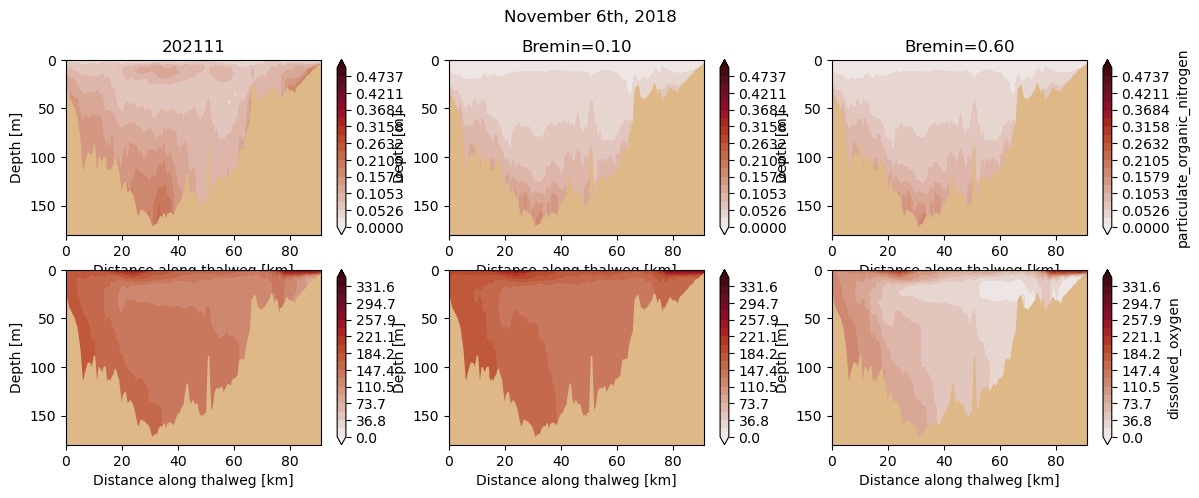

In [11]:
fig, ax = plt.subplots(2, 3, figsize = (14, 5))
old0=vis.contour_thalweg(ax[0,0],df_biolTlr0.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_HC,cbar_args={'label':''})
new1=vis.contour_thalweg(ax[0,1],df_biolTlr1.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_HC,cbar_args={'label':''})
new2=vis.contour_thalweg(ax[0,2],df_biolTlr2.variables[modvar1][tt,...],bathy,mesh,clevels=level_pon,cmap=cm.amp,thalweg_file=thalweg_HC,cbar_args={'label':modvar1})
old0=vis.contour_thalweg(ax[1,0],df_chemTlr0.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_HC,cbar_args={'label':''})
new1=vis.contour_thalweg(ax[1,1],df_chemTlr1.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_HC,cbar_args={'label':''})
new2=vis.contour_thalweg(ax[1,2],df_chemTlr2.variables[modvar2][tt,...],bathy,mesh,clevels=level_oxy,cmap=cm.amp,thalweg_file=thalweg_HC,cbar_args={'label':modvar2})

ax[0,0].set_ylim([180, 0])
ax[0,1].set_ylim([180, 0])
ax[0,2].set_ylim([180, 0])
ax[1,0].set_ylim([180, 0])
ax[1,1].set_ylim([180, 0])
ax[1,2].set_ylim([180, 0])
ax[0,0].set_title('202111')
ax[0,1].set_title('Bremin=0.10')
ax[0,2].set_title('Bremin=0.60')
fig.suptitle('November 6th, 2018')